In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

In [2]:
trj1 = np.loadtxt('data/trj1.txt')
trj2 = np.loadtxt('data/trj2.txt')

* mass - kg
* coordinates - m
* potential energy - J

### a) Plot trajectory and color  by time step:

In [24]:
def plot_trajectory(traj):
    plt.figure(figsize=(7,7))
    plt.scatter(traj[:,0], traj[:,1], s=5, c=np.arange(len(traj[:,0])))
    plt.title('Positions colored by time step')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
    plt.axis('equal')

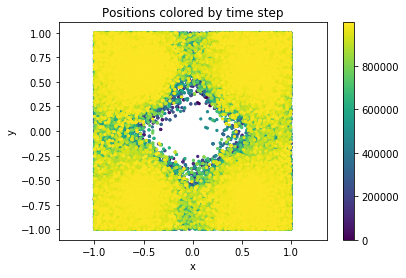

In [23]:
plot_trajectory(trj1)

### b) Discretize position and plot potential as function of position:

In [54]:
def plot_potential(traj):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
#     ax.set_title('Potential field k={} and K={}'.format(k, K))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('V(x, y)')
#     x = traj[:,0]
#     y = traj[:,1]
    x = np.linspace(min(traj[:,0]), max(traj[:,0]), len(traj[:,0]))
    y = np.linspace(min(traj[:,1]), max(traj[:,1]), len(traj[:,1]))
    X, Y = np.meshgrid(x, y)
    print(X)
#     zs = np.array([pot(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
    zs = np.array([traj[:,2], traj[:,2]])
    Z = zs.reshape(X.shape)
    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)

[[-0.7542     -0.74944747 -0.74469495 ... -0.29320505 -0.28845253
  -0.2837    ]
 [-0.7542     -0.74944747 -0.74469495 ... -0.29320505 -0.28845253
  -0.2837    ]
 [-0.7542     -0.74944747 -0.74469495 ... -0.29320505 -0.28845253
  -0.2837    ]
 ...
 [-0.7542     -0.74944747 -0.74469495 ... -0.29320505 -0.28845253
  -0.2837    ]
 [-0.7542     -0.74944747 -0.74469495 ... -0.29320505 -0.28845253
  -0.2837    ]
 [-0.7542     -0.74944747 -0.74469495 ... -0.29320505 -0.28845253
  -0.2837    ]]


ValueError: shape mismatch: objects cannot be broadcast to a single shape

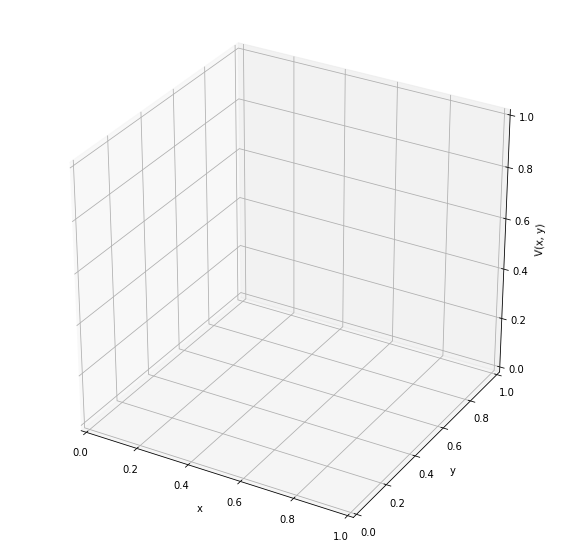

In [55]:
plot_potential(trj1[:100])

In [ ]:
    ax[0].plot(traj[:,0], traj[:,1], '--', color='grey')
    ax[0].scatter(traj[:,0], traj[:,1], c=traj[:,0])
    ax[0].set_title('Positions colored by potential energy')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')

In [ ]:
def position_histogram(traj):
    plt.figure(figsize=(7,7))
    plt.hist2d(traj[:,0], traj[:,1],  bins=100)
    plt.title('2D histogram of positions')
    plt.xlabel('x')
    plt.ylabel('y')

In [ ]:
position_histogram(trj1)

In [ ]:
def plot_potential(traj):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('Potential field k={} and K={}'.format(k, K))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('V(x, y)')
    x = y = np.linspace(-1, 1, 101)
    X, Y = np.meshgrid(x, y)
    zs = np.array([pot(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)
    ax.plot_surface(X, Y, Z,cmap=cm.coolwarm)